#Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.autograd import Variable

#Reading the Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Membaca file CSV
df = pd.read_csv("Skripsi.csv", sep=';', parse_dates=['Tanggal'])

In [ ]:
df

,Tanggal,Tn,Tx,RR,ff_x
0,01/07/2020,"22,8",33,NaN,3.0
1,02/07/2020,"23,5","31,2",NaN,5.0
2,03/07/2020,NaN,"31,7",19,4.0
3,04/07/2020,"21,2","29,5","32,7",4.0
4,05/07/2020,"21,4","31,5",NaN,5.0
...,...,...,...,...,...
1463,03/07/2024,23,"33,2",NaN,18.0
1464,04/07/2024,"22,4",33,2,5.0
1465,05/07/2024,23,"33,2","28,6",12.0
1466,06/07/2024,23,"30,3","3,4",9.0


In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce')

In [ ]:
df.isnull().sum()

,0
Tanggal,0
Tn,128
Tx,66
RR,358
ff_x,4


In [ ]:
# Mengganti koma dengan titik di seluruh kolom kecuali Tanggal agar bisa dikonversi ke Float
for col in df.columns:
    if df[col].dtype == 'object' and col != 'Tanggal':
        df[col] = df[col].str.replace(',', '.', regex=False)

# Konversi semua kolom numerik ke float
numeric_cols = ['Tn', 'Tx', 'RR', 'ff_x']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Mengecek tipe data kolom
print(df.dtypes)

Tanggal    datetime64[ns]
Tn                float64
Tx                float64
RR                float64
ff_x              float64
dtype: object


In [ ]:
# Ekstraksi fitur waktu
df['Year'] = df['Tanggal'].dt.year  # Tahun
df['Month'] = df['Tanggal'].dt.month  # Bulan
df['Day'] = df['Tanggal'].dt.day  # Hari


In [ ]:
df

,Tanggal,Tn,Tx,RR,ff_x,Year,Month,Day
0,2020-07-01,22.8,33.0,NaN,3.0,2020,7,1
1,2020-07-02,23.5,31.2,NaN,5.0,2020,7,2
2,2020-07-03,NaN,31.7,19.0,4.0,2020,7,3
3,2020-07-04,21.2,29.5,32.7,4.0,2020,7,4
4,2020-07-05,21.4,31.5,NaN,5.0,2020,7,5
...,...,...,...,...,...,...,...,...
1463,2024-07-03,23.0,33.2,NaN,18.0,2024,7,3
1464,2024-07-04,22.4,33.0,2.0,5.0,2024,7,4
1465,2024-07-05,23.0,33.2,28.6,12.0,2024,7,5
1466,2024-07-06,23.0,30.3,3.4,9.0,2024,7,6


#Data Preprocessing

###Handling Missing Values

In [ ]:
# Memeriksa jumlah missing values di setiap kolom
print(df.isnull().sum())


Tanggal      0
Tn         128
Tx          66
RR         358
ff_x         4
Year         0
Month        0
Day          0
dtype: int64


In [ ]:
# # Mengganti nilai 8888 dan kosong dengan NaN, lalu isi setiap nilai NaN dengan forward fill
df.replace(8888, np.nan, inplace=True)

In [ ]:
# def is_invalid(value):
#     return pd.isna(value) or value == 8888

# def fill_with_avg_rr(rr_series):
#     rr_filled = rr_series.copy()

#     for i in range(len(rr_filled)):
#         if is_invalid(rr_filled[i]):
#             # Cari nilai valid di atas
#             prev = i - 1
#             while prev >= 0 and is_invalid(rr_filled[prev]):
#                 prev -= 1

#             # Cari nilai valid di bawah
#             next = i + 1
#             while next < len(rr_filled) and is_invalid(rr_filled[next]):
#                 next += 1

#             prev_value = rr_filled[prev] if prev >= 0 else np.nan
#             next_value = rr_filled[next] if next < len(rr_filled) else np.nan

#             # Imputasi dengan rata-rata dua nilai valid
#             if not pd.isna(prev_value) and not pd.isna(next_value):
#                 rr_filled[i] = (prev_value + next_value) / 2
#             elif not pd.isna(prev_value):
#                 rr_filled[i] = prev_value
#             elif not pd.isna(next_value):
#                 rr_filled[i] = next_value
#             else:
#                 rr_filled[i] = np.nan  # Jika tidak ditemukan nilai valid sama sekali

#     return rr_filled

In [ ]:
df['RR'] = df['RR'].fillna(0)

# 2. Ffill untuk kolom selain RR
df[['Tn', 'Tx', 'ff_x']] = df[['Tn', 'Tx', 'ff_x']].fillna(method='ffill')

# Memeriksa kembali nilai null
print(df.isnull().sum())  # Pastikan tidak ada lagi nilai null

Tanggal    0
Tn         0
Tx         0
RR         0
ff_x       0
Year       0
Month      0
Day        0
dtype: int64


<ipython-input-14-2b3286df6ca3>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['Tn', 'Tx', 'ff_x']] = df[['Tn', 'Tx', 'ff_x']].fillna(method='ffill')


In [ ]:
df

,Tanggal,Tn,Tx,RR,ff_x,Year,Month,Day
0,2020-07-01,22.8,33.0,0.0,3.0,2020,7,1
1,2020-07-02,23.5,31.2,0.0,5.0,2020,7,2
2,2020-07-03,23.5,31.7,19.0,4.0,2020,7,3
3,2020-07-04,21.2,29.5,32.7,4.0,2020,7,4
4,2020-07-05,21.4,31.5,0.0,5.0,2020,7,5
...,...,...,...,...,...,...,...,...
1463,2024-07-03,23.0,33.2,0.0,18.0,2024,7,3
1464,2024-07-04,22.4,33.0,2.0,5.0,2024,7,4
1465,2024-07-05,23.0,33.2,28.6,12.0,2024,7,5
1466,2024-07-06,23.0,30.3,3.4,9.0,2024,7,6


#EDA

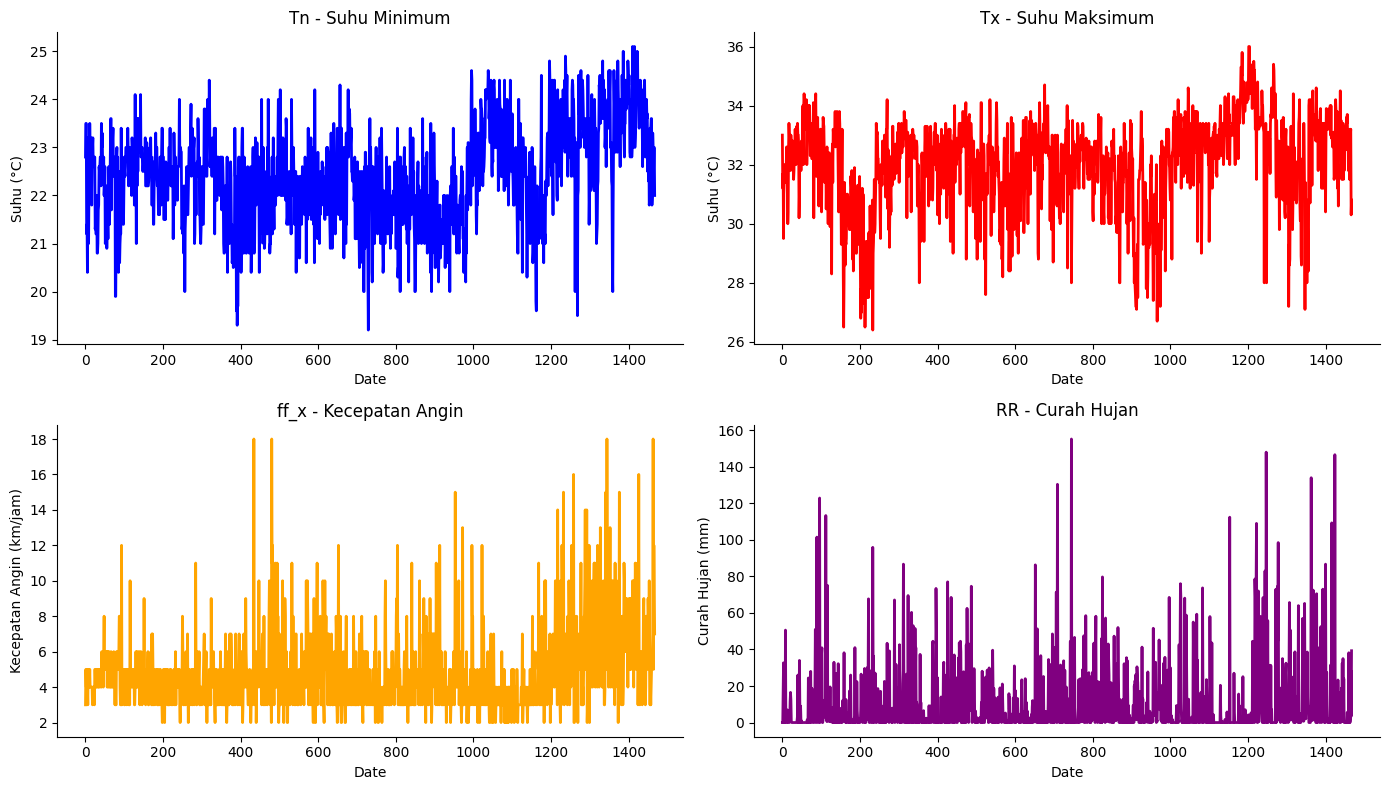

In [ ]:
import matplotlib.pyplot as plt

# Mengatur style default
plt.style.use('default')

# Membuat figure dengan ukuran lebih besar dan 2 baris, 3 kolom
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # Ukuran figure, 2 baris, 3 kolom

# Plot setiap kolom pada subplot yang berbeda

# Baris pertama (kolom pertama dan kedua)
axes[0, 0].plot(df['Tn'], linewidth=2, color='blue')
axes[0, 0].set_title("Tn - Suhu Minimum")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Suhu (°C)")
axes[0, 0].grid(False)
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)

axes[0, 1].plot(df['Tx'], linewidth=2, color='red')
axes[0, 1].set_title("Tx - Suhu Maksimum")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Suhu (°C)")
axes[0, 1].grid(False)
axes[0, 1].spines['top'].set_visible(False)
axes[0, 1].spines['right'].set_visible(False)


axes[1, 1].plot(df['RR'], linewidth=2, color='purple')
axes[1, 1].set_title("RR - Curah Hujan")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Curah Hujan (mm)")
axes[1, 1].grid(False)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# Baris terakhir (kolom kelima)
axes[1, 0].plot(df['ff_x'], linewidth=2, color='orange')
axes[1, 0].set_title("ff_x - Kecepatan Angin")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Kecepatan Angin (km/jam)")
axes[1, 0].grid(False)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# Mengatur layout agar lebih rapi
plt.tight_layout()
plt.show()


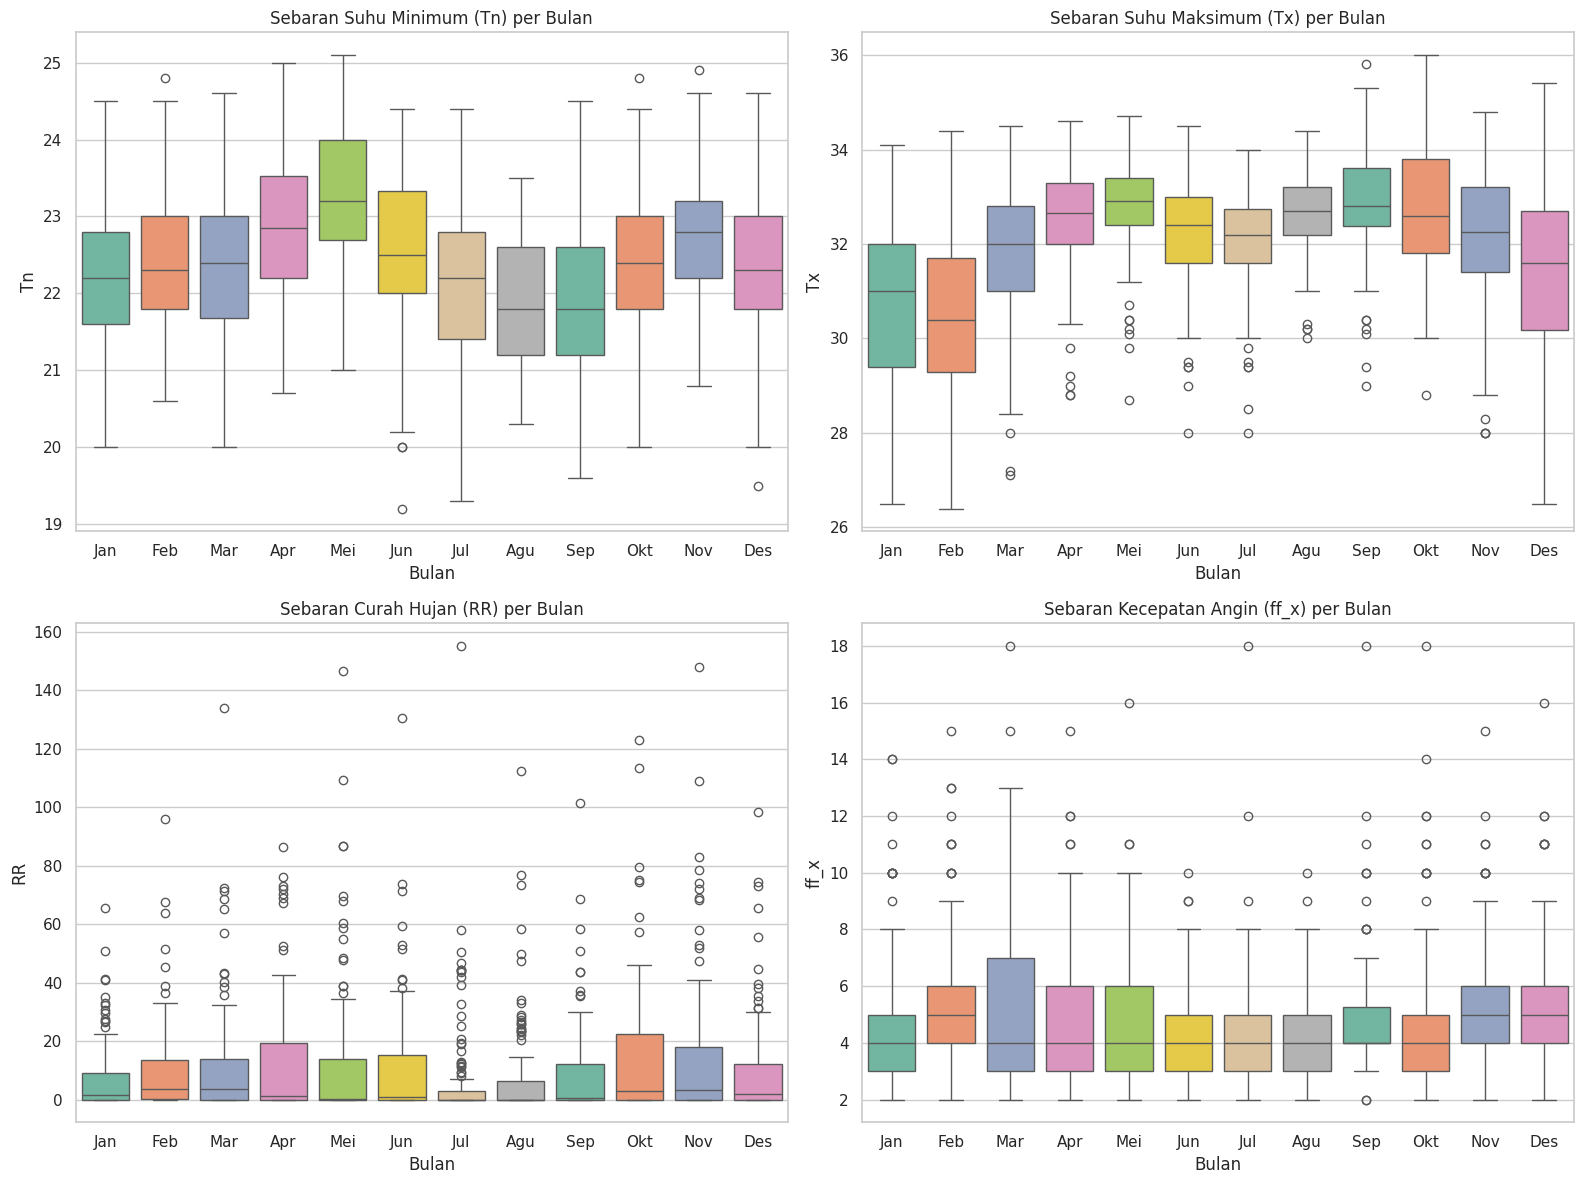

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan kolom 'Bulan' ada
df['Bulan'] = df['Tanggal'].dt.month

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

plot_data = [
    ('Tn', 'Sebaran Suhu Minimum (Tn) per Bulan'),
    ('Tx', 'Sebaran Suhu Maksimum (Tx) per Bulan'),
    ('RR', 'Sebaran Curah Hujan (RR) per Bulan'),
    ('ff_x', 'Sebaran Kecepatan Angin (ff_x) per Bulan')
]

for i, (col, title) in enumerate(plot_data):
    sns.boxplot(x='Bulan', y=col, data=df, ax=axes[i], hue='Bulan', palette='Set2', legend=False)
    axes[i].set_title(title)
    axes[i].set_xlabel('Bulan')
    axes[i].set_ylabel(col)
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])

plt.tight_layout()
plt.show()


<ipython-input-18-2966f7328758>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Quarter', y=col, data=df, ax=axes[i], palette='Set3')
<ipython-input-18-2966f7328758>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Quarter', y=col, data=df, ax=axes[i], palette='Set3')
<ipython-input-18-2966f7328758>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Quarter', y=col, data=df, ax=axes[i], palette='Set3')
<ipython-input-18-2966f7328758>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

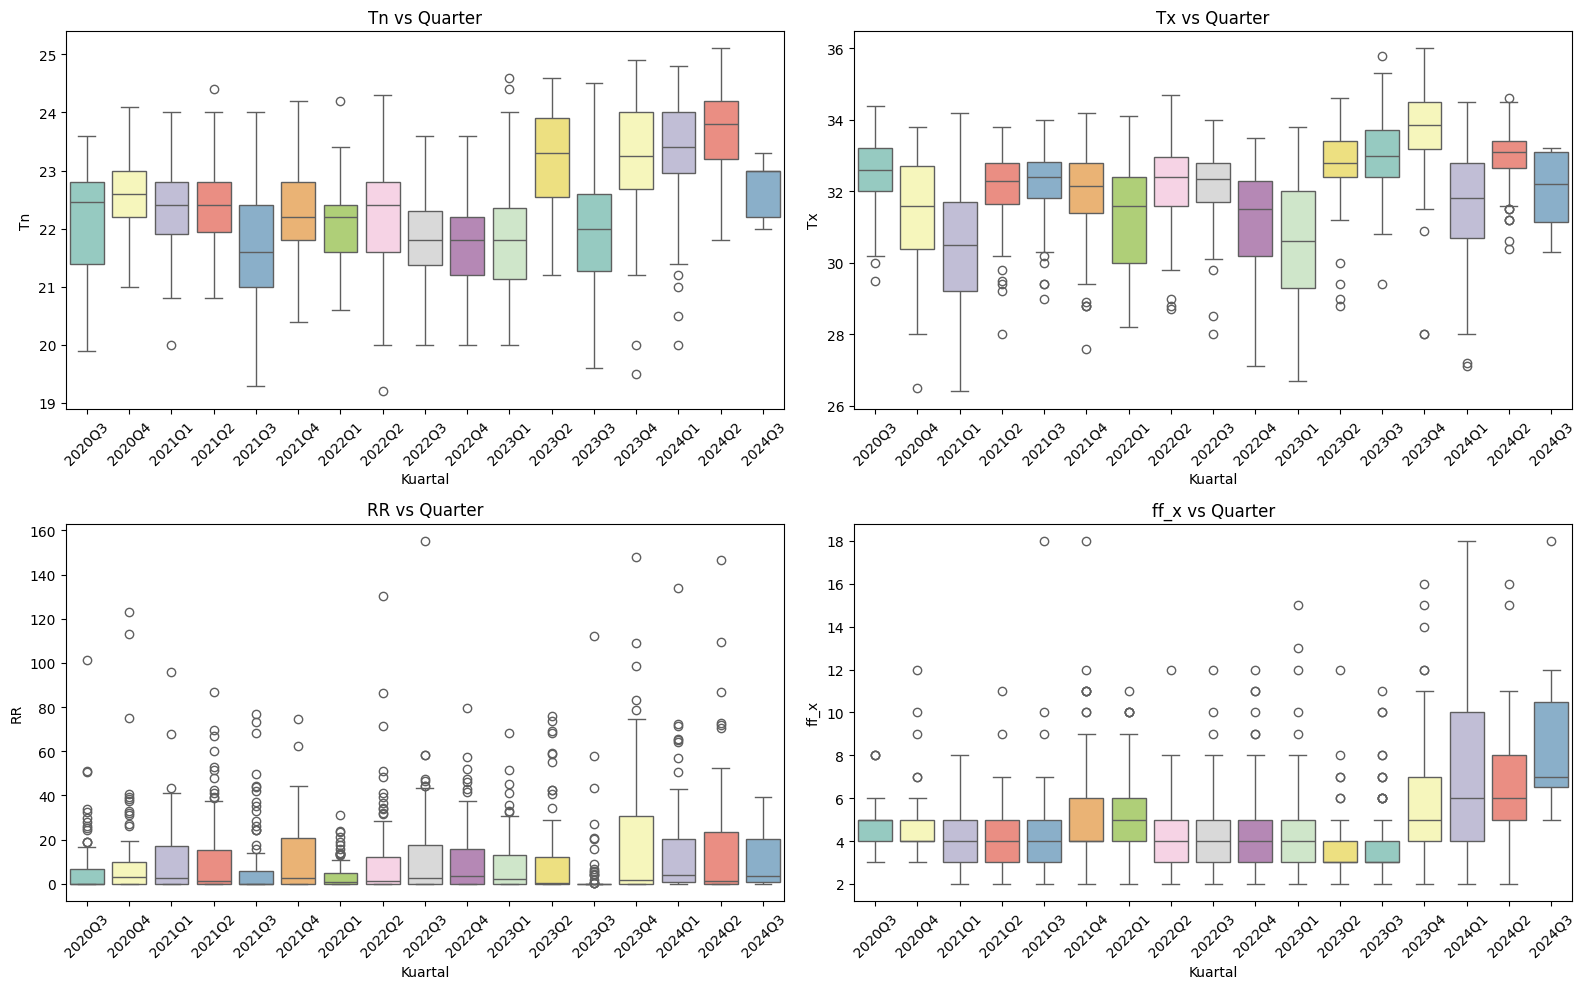

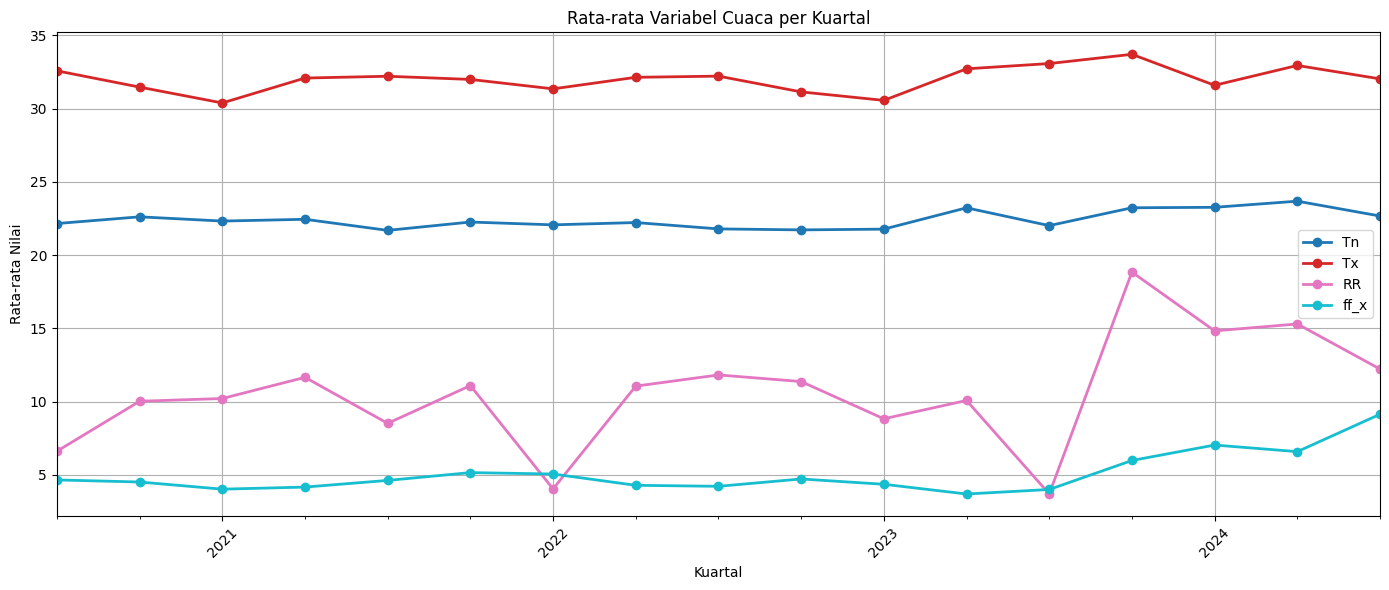

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom Quarter sudah ada
df['Quarter'] = df['Tanggal'].dt.to_period('Q')

# --- BOX PLOT per Quarter ---
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(['Tn', 'Tx', 'RR', 'ff_x']):
    sns.boxplot(x='Quarter', y=col, data=df, ax=axes[i], palette='Set3')
    axes[i].set_title(f'{col} vs Quarter')
    axes[i].set_xlabel("Kuartal")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# --- RATA-RATA per Quarter (Line Plot) ---
df_quarterly = df.groupby('Quarter')[['Tn', 'Tx', 'RR', 'ff_x']].mean()

df_quarterly.plot(marker='o', figsize=(14, 6), linewidth=2, cmap='tab10')
plt.title("Rata-rata Variabel Cuaca per Kuartal")
plt.ylabel("Rata-rata Nilai")
plt.xlabel("Kuartal")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


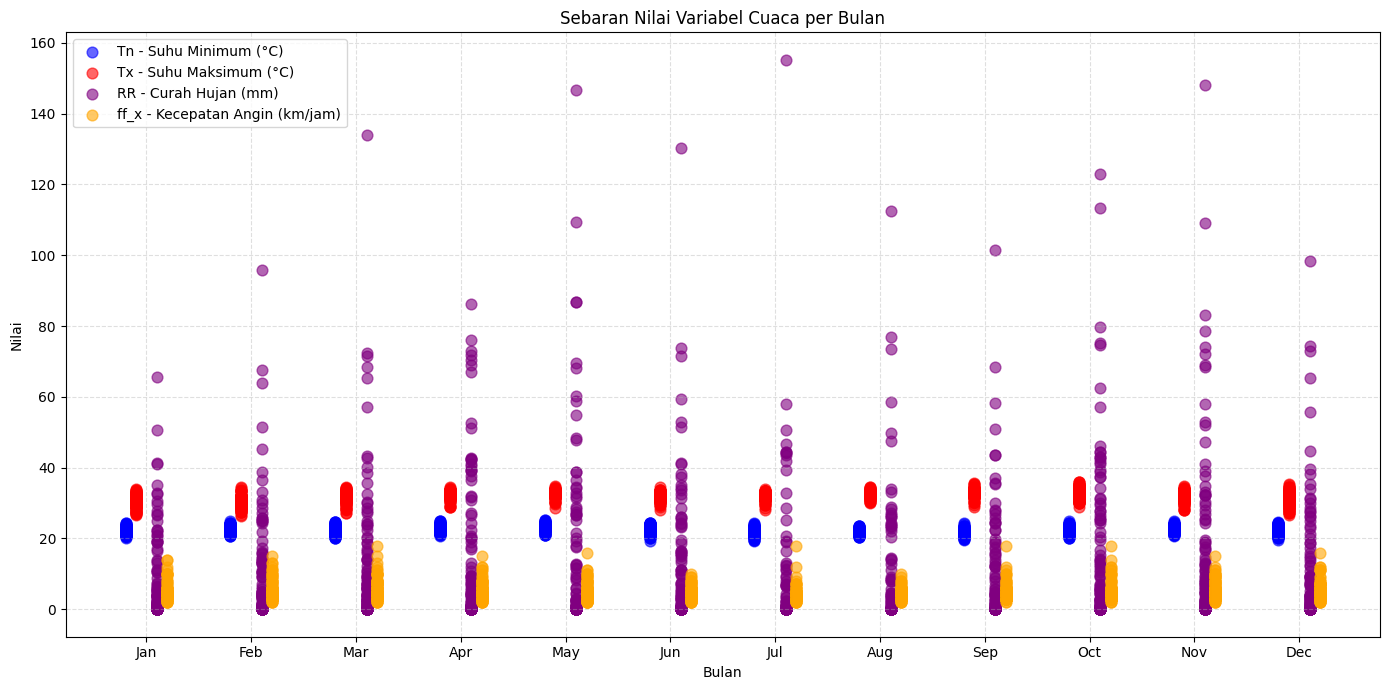

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan kolom Bulan ada
df['Bulan'] = df['Tanggal'].dt.month

plt.figure(figsize=(14, 7))

# Menggunakan offset untuk menempatkan variabel-variabel pada posisi yang berbeda
offsets = [-0.2, -0.1, 0.1, 0.2]  # Offset untuk menempatkan variabel-variabel secara berurutan

# Plot titik untuk setiap variabel
plt.scatter(df['Bulan'] + offsets[0], df['Tn'], color='blue', label='Tn - Suhu Minimum (°C)', alpha=0.6, s=60)  # Ukuran titik diperbesar
plt.scatter(df['Bulan'] + offsets[1], df['Tx'], color='red', label='Tx - Suhu Maksimum (°C)', alpha=0.6, s=60)  # Ukuran titik diperbesar
plt.scatter(df['Bulan'] + offsets[2], df['RR'], color='purple', label='RR - Curah Hujan (mm)', alpha=0.6, s=60)  # Ukuran titik diperbesar
plt.scatter(df['Bulan'] + offsets[3], df['ff_x'], color='orange', label='ff_x - Kecepatan Angin (km/jam)', alpha=0.6, s=60)  # Ukuran titik diperbesar

# Format sumbu dan tampilan
plt.title('Sebaran Nilai Variabel Cuaca per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Nilai')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


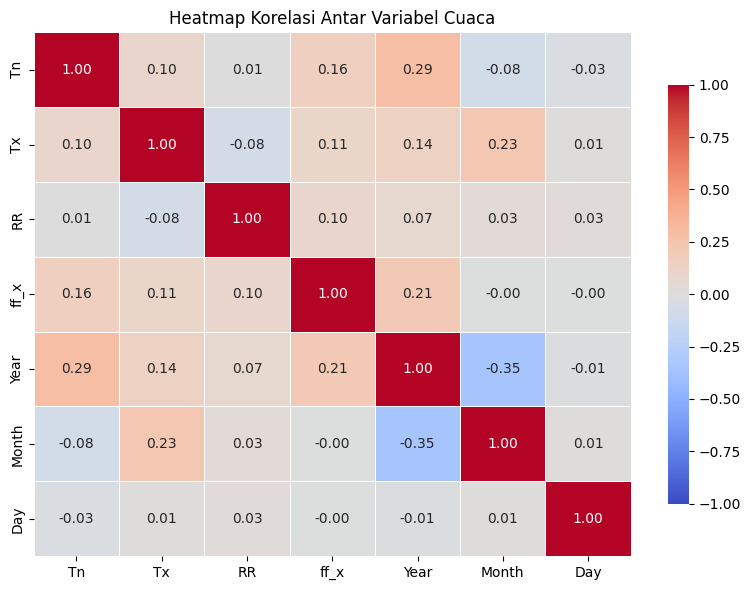

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung korelasi antar variabel numerik
corr = df[['Tn', 'Tx', 'RR', 'ff_x', 'Year', 'Month', 'Day']].corr()

# Membuat heatmap dari matriks korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})

# Menambahkan judul dan menampilkan plot
plt.title('Heatmap Korelasi Antar Variabel Cuaca')
plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Tanggal,Tn,Tx,RR,ff_x,Year,Month,Day,Bulan,Quarter
0,2020-07-01,22.8,33.0,0.0,3.0,2020,7,1,7,2020Q3
1,2020-07-02,23.5,31.2,0.0,5.0,2020,7,2,7,2020Q3
2,2020-07-03,23.5,31.7,19.0,4.0,2020,7,3,7,2020Q3
3,2020-07-04,21.2,29.5,32.7,4.0,2020,7,4,7,2020Q3
4,2020-07-05,21.4,31.5,0.0,5.0,2020,7,5,7,2020Q3


In [ ]:
df_tanggal = df['Tanggal'].tail(147)

df_tanggal.to_csv('tanggal.csv', index=False)

#Modelling

## Create Function

In [ ]:
def create_sliding_window(data, target_cols, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][target_cols])
    return np.array(X), np.array(y)

In [ ]:
def split_data(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    total_len = len(X)

    # Validasi total rasio harus 1.0
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Total rasio harus sama dengan 1.0"

    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

## GRU

### Splitting Data

In [ ]:
# Inisialisasi Fitur untuk GRU
features_gru = ['Tn', 'Tx', 'RR', 'ff_x']
df_gru = df[features_gru].copy()  # Buat salinan agar tidak memengaruhi df asli

scaler_gru = MinMaxScaler()
scaled_data_gru = scaler_gru.fit_transform(df_gru)

# Konversi ke DataFrame lagi agar bisa indexing kolom
scaled_df_gru = pd.DataFrame(scaled_data_gru, columns=features_gru)

# Gunakan sliding window
target_cols = features_gru
window_size_gru = 4  # sama dengan model sebelumnya
X_gru, y_gru = create_sliding_window(scaled_df_gru.values, scaled_df_gru.columns.get_indexer(target_cols), window_size_gru)

In [ ]:
(X_train_gru, y_train_gru), (X_val_gru, y_val_gru), (X_test_gru, y_test_gru) = split_data(
    X_gru, y_gru, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

In [ ]:
print("X_train_gru:", X_train_gru.shape)
print("X_val_gru:", X_val_gru.shape)
print("X_test_gru:", X_test_gru.shape)

X_train_gru: (1171, 4, 4)
X_val_gru: (146, 4, 4)
X_test_gru: (147, 4, 4)


### Data Loader

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Konversi ke tensor untuk GRU
X_train_tensor_gru = torch.tensor(X_train_gru, dtype=torch.float32)
y_train_tensor_gru = torch.tensor(y_train_gru, dtype=torch.float32)
X_val_tensor_gru = torch.tensor(X_val_gru, dtype=torch.float32)
y_val_tensor_gru = torch.tensor(y_val_gru, dtype=torch.float32)

# Buat DataLoader untuk GRU
train_loader_gru = DataLoader(TensorDataset(X_train_tensor_gru, y_train_tensor_gru), batch_size=16, shuffle=True)
val_loader_gru = DataLoader(TensorDataset(X_val_tensor_gru, y_val_tensor_gru), batch_size=16)

### Define Model

In [ ]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)  # hanya hidden terakhir

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]        # Ambil output timestep terakhir
        out = self.fc(out)
        return out

In [ ]:
input_dim = X_train_gru.shape[2]
hidden_dim = 128
output_dim = y_train_gru.shape[1]  # jumlah target
# Inisialisasi parameter model GRU
criterion_gru = nn.MSELoss()
model_gru = GRUModel(input_dim, hidden_dim, output_dim)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.0001)

num_epochs_gru = 200
patience_gru = 20
best_val_loss_gru = np.inf
wait_gru = 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


### Train Model

In [ ]:
train_losses_gru = []
val_losses_gru = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gru.to(device)

for epoch in range(num_epochs_gru):
    model_gru.train()
    train_loss = 0.0
    for xb, yb in train_loader_gru:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_gru.zero_grad()
        pred = model_gru(xb)   # Model hanya memerlukan output timestep terakhir
        loss = criterion_gru(pred, yb)
        loss.backward()
        optimizer_gru.step()
        train_loss += loss.item()

    model_gru.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader_gru:
            xb, yb = xb.to(device), yb.to(device)
            pred = model_gru(xb)
            loss = criterion_gru(pred, yb)
            val_loss += loss.item()

    # Rata-rata loss
    avg_train_loss = train_loss / len(train_loader_gru)
    avg_val_loss = val_loss / len(val_loader_gru)
    train_losses_gru.append(avg_train_loss)
    val_losses_gru.append(avg_val_loss)

    print(f"[GRU] Epoch {epoch+1}/{num_epochs_gru} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss_gru:
        best_val_loss_gru = avg_val_loss
        wait_gru = 0
        torch.save(model_gru.state_dict(), "best_model_gru.pt")
        print("✅ [GRU] Best model disimpan.")
    else:
        wait_gru += 1
        if wait_gru >= patience_gru:
            print("⛔️ [GRU] Early stopping triggered.")
            break

[GRU] Epoch 1/200 | Train Loss: 0.1078 | Val Loss: 0.1214
✅ [GRU] Best model disimpan.
[GRU] Epoch 2/200 | Train Loss: 0.0326 | Val Loss: 0.0372
✅ [GRU] Best model disimpan.
[GRU] Epoch 3/200 | Train Loss: 0.0166 | Val Loss: 0.0347
✅ [GRU] Best model disimpan.
[GRU] Epoch 4/200 | Train Loss: 0.0164 | Val Loss: 0.0350
[GRU] Epoch 5/200 | Train Loss: 0.0163 | Val Loss: 0.0346
✅ [GRU] Best model disimpan.
[GRU] Epoch 6/200 | Train Loss: 0.0162 | Val Loss: 0.0335
✅ [GRU] Best model disimpan.
[GRU] Epoch 7/200 | Train Loss: 0.0161 | Val Loss: 0.0335
✅ [GRU] Best model disimpan.
[GRU] Epoch 8/200 | Train Loss: 0.0160 | Val Loss: 0.0337
[GRU] Epoch 9/200 | Train Loss: 0.0158 | Val Loss: 0.0339
[GRU] Epoch 10/200 | Train Loss: 0.0157 | Val Loss: 0.0324
✅ [GRU] Best model disimpan.
[GRU] Epoch 11/200 | Train Loss: 0.0156 | Val Loss: 0.0334
[GRU] Epoch 12/200 | Train Loss: 0.0154 | Val Loss: 0.0329
[GRU] Epoch 13/200 | Train Loss: 0.0154 | Val Loss: 0.0327
[GRU] Epoch 14/200 | Train Loss: 0.0152

In [ ]:
# Load the best model for GRU only
model_gru.load_state_dict(torch.load("best_model_gru.pt"))
model_gru.eval()  # Set the model to evaluation mode

# Ubah X_test_gru menjadi tensor
X_test_gru_tensor = torch.tensor(X_test_gru, dtype=torch.float32)

# Lakukan prediksi tanpa gradient tracking
with torch.no_grad():
    y_pred_gru_tensor = model_gru(X_test_gru_tensor)  # Memanggil model GRU untuk prediksi
    y_pred_gru = y_pred_gru_tensor.numpy()  # Konversi hasil prediksi ke numpy untuk evaluasi

### Evaluation Model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-8  # untuk mencegah pembagian nol
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Ambil indeks target berdasarkan nama kolom scaler
target_indices = [np.where(scaler_gru.feature_names_in_ == col)[0][0] for col in target_cols]

# Invers transform y_test
dummy_test = np.zeros((len(y_test_gru), scaler_gru.n_features_in_))
for idx, col_idx in enumerate(target_indices):
    dummy_test[:, col_idx] = y_test_gru[:, idx]
y_test_gru_inv = scaler_gru.inverse_transform(dummy_test)[:, target_indices]

# Invers transform prediksi
dummy_pred = np.zeros((len(y_pred_gru), scaler_gru.n_features_in_))
for idx, col_idx in enumerate(target_indices):
    dummy_pred[:, col_idx] = y_pred_gru[:, idx]
y_pred_gru_inv = scaler_gru.inverse_transform(dummy_pred)[:, target_indices]

# Inisialisasi dictionary untuk GRU
mse_gru_dict = {}
rmse_gru_dict = {}
mae_gru_dict = {}

print("📊 Evaluasi GRU pada Test Set:")
for i, var in enumerate(target_cols):
    mse_val = mean_squared_error(y_test_gru_inv[:, i], y_pred_gru_inv[:, i])
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_test_gru_inv[:, i], y_pred_gru_inv[:, i])

    mse_gru_dict[var] = mse_val
    rmse_gru_dict[var] = rmse_val
    mae_gru_dict[var] = mae_val

    print(f"{var} - MSE: {mse_val:.2f}, RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}")

📊 Evaluasi GRU pada Test Set:
Tn - MSE: 0.79, RMSE: 0.89, MAE: 0.73
Tx - MSE: 1.50, RMSE: 1.22, MAE: 0.97
RR - MSE: 634.59, RMSE: 25.19, MAE: 17.71
ff_x - MSE: 13.19, RMSE: 3.63, MAE: 2.63


### Visualization

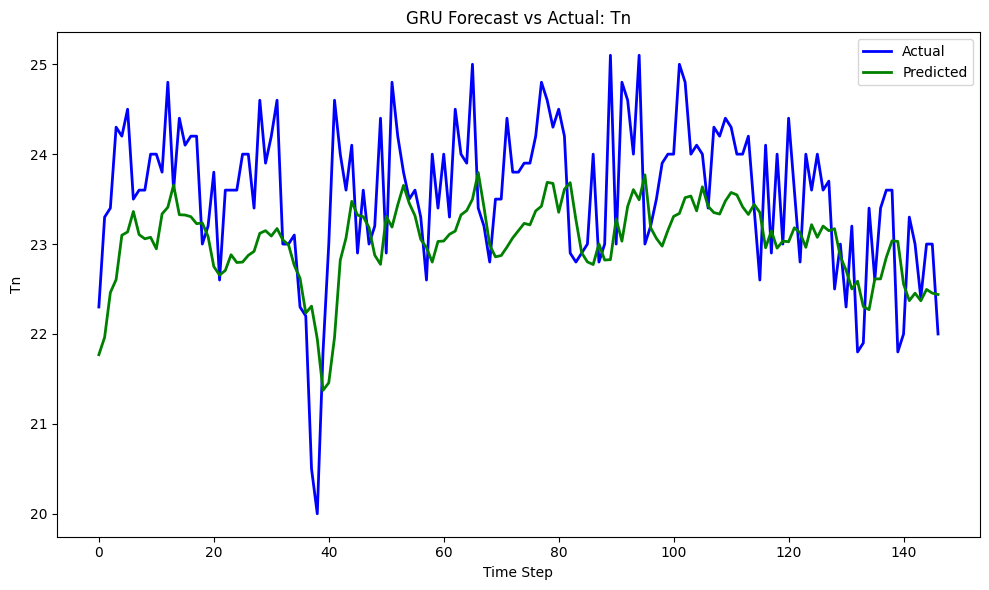

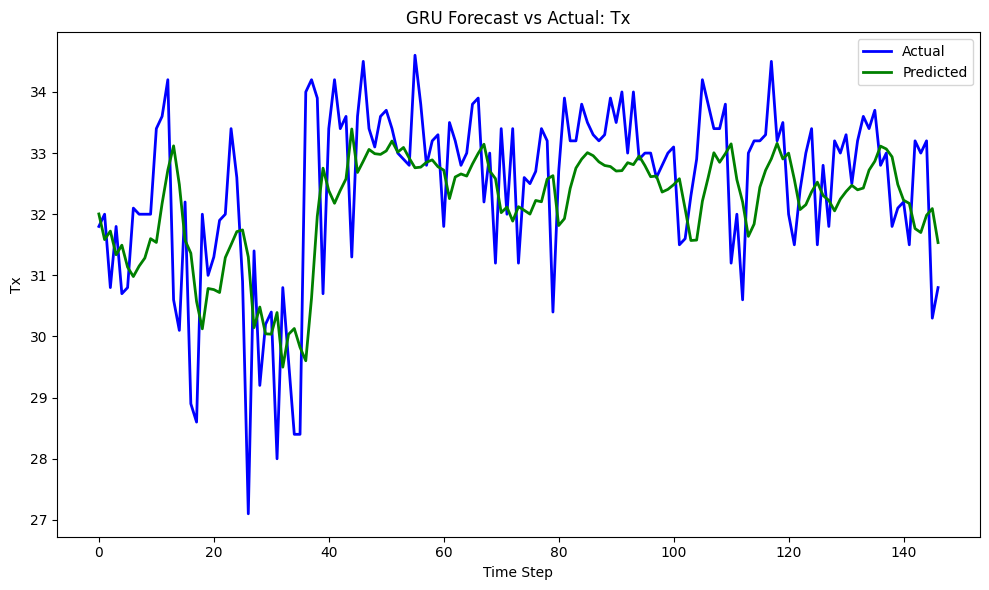

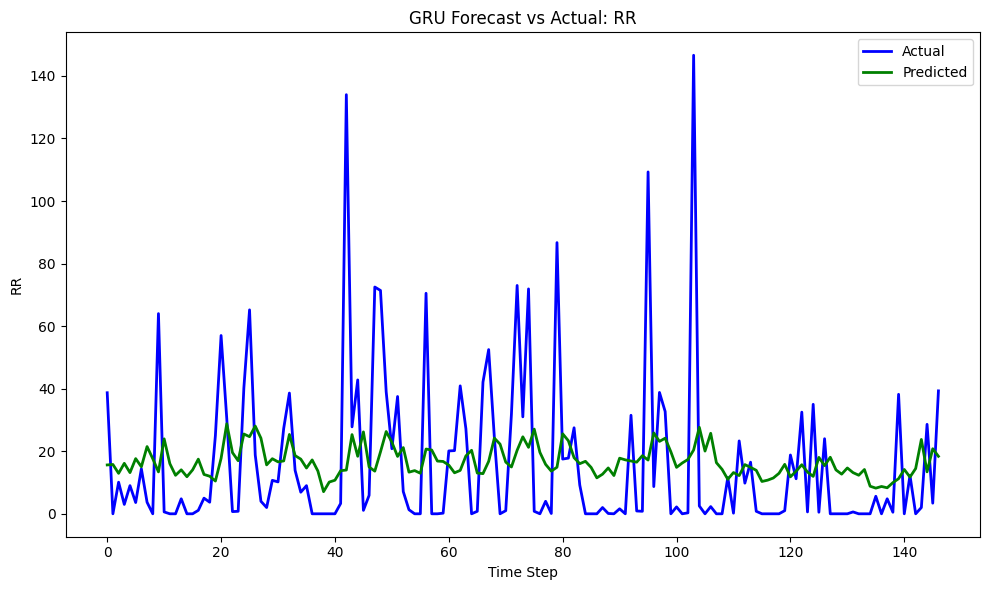

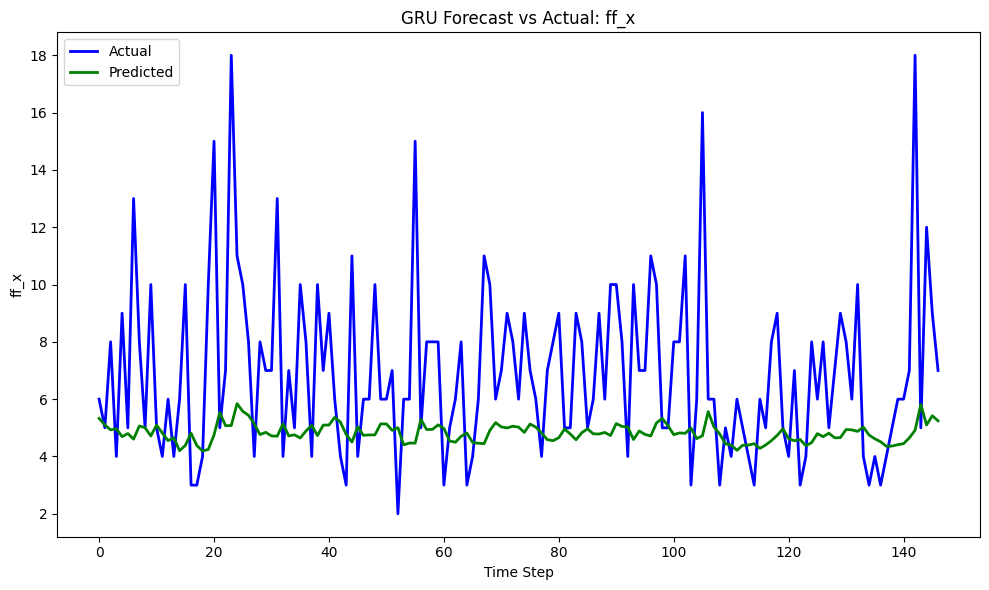

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi GRU-LSTM - Satu gambar per variabel
for i, var in enumerate(target_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_gru_inv[:, i], label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred_gru_inv[:, i], label='Predicted', color='green', linewidth=2)
    plt.title(f'GRU Forecast vs Actual: {var}')
    plt.xlabel('Time Step')
    plt.ylabel(var)

    plt.legend()
    plt.tight_layout()
    plt.show()

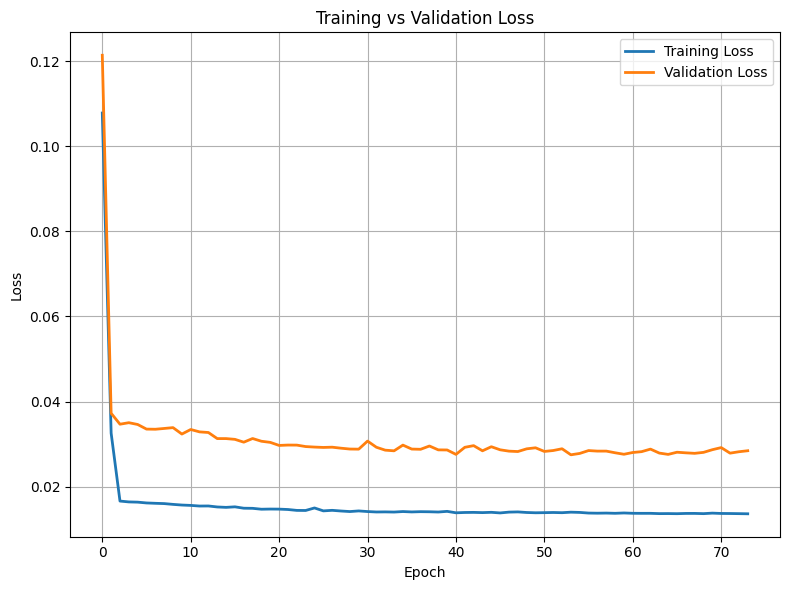

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses_gru, label='Training Loss', linewidth=2)
plt.plot(val_losses_gru, label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Tabel Evaluasi

In [ ]:
# import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'serif'
# for i, var in enumerate(target_cols):
#     # Membuat figure dan satu subplot untuk setiap target
#     fig, ax = plt.subplots(figsize=(10, 6))

#     # Plot data aktual dan hasil prediksi dari masing-masing model
#     ax.plot(y_test_inv[:, i], label='Actual', color='blue', linewidth=2)
#     ax.plot(y_pred_inv[:, i], label='GRU-LSTM', color='red', linewidth=2)
#     ax.plot(y_pred_gru_inv[:, i], label='GRU', color='green', linewidth=2)
#     ax.plot(y_pred_lstm_inv[:, i], label='LSTM', color='orange', linewidth=2)

#     # Menambahkan judul dan legenda
#     ax.set_title(f'{var} - All Models Forecast vs Actual')
#     ax.legend()

#     # Menghilangkan grid dan border
#     ax.grid(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Menampilkan plot
#     plt.tight_layout()
#     plt.show()

In [ ]:
# summary_df = pd.DataFrame({
#     'Variabel': target_cols,

#     'MSE_GRULSTM': [mse_dict[var] for var in target_cols],
#     'RMSE_GRULSTM': [rmse_dict[var] for var in target_cols],
#     'MAE_GRULSTM': [mae_dict[var] for var in target_cols],

#     'MSE_GRU': [mse_gru_dict[var] for var in target_cols],
#     'RMSE_GRU': [rmse_gru_dict[var] for var in target_cols],
#     'MAE_GRU': [mae_gru_dict[var] for var in target_cols],

#     'MSE_LSTM': [mse_lstm_dict[var] for var in target_cols],
#     'RMSE_LSTM': [rmse_lstm_dict[var] for var in target_cols],
#     'MAE_LSTM': [mae_lstm_dict[var] for var in target_cols],
# })

# summary_df

In [ ]:
# # Ubah ke long format dulu
# summary_melted = summary_df.melt(id_vars='Variabel', var_name='Metric_Model', value_name='Value')

# # Pisahkan 'Metric' dan 'Model' dari kolom 'Metric_Model'
# summary_melted[['Metric', 'Model']] = summary_melted['Metric_Model'].str.extract(r'(\w+)_([\w]+)')

# # Pivot agar Model jadi kolom, Variabel jadi kolom, dan Metric jadi baris
# summary_pivoted = summary_melted.pivot_table(index=['Metric', 'Model'], columns='Variabel', values='Value')

# # Opsional: rapikan nama kolom
# summary_pivoted = summary_pivoted.reset_index()

# summary_pivoted

In [ ]:
# summary_pivoted.to_csv("/content/drive/MyDrive/TUGAS AKHIR/Evaluasi Tabel.csv", index=False, sep=";", decimal=',')

## Save Model

In [ ]:
# Buat dataframe untuk y_true
df_true = pd.DataFrame(y_test_gru_inv, columns=[f"{col}_true" for col in target_cols])
# Dataframe untuk masing-masing prediksi
df_pred_gru = pd.DataFrame(y_pred_gru_inv, columns=[f"{col}_pred_gru" for col in target_cols])

# Gabungkan semua
df_all_preds = pd.concat([df_true, df_pred_gru], axis=1)

# Simpan ke CSV
save_path_preds = "y_true_vs_pred_GRU.csv"
df_all_preds.to_csv(save_path_preds, index=False, sep=";", decimal=',')

print(f"✅ DataFrame semua prediksi berhasil disimpan di: {save_path_preds}")

✅ DataFrame semua prediksi berhasil disimpan di: y_true_vs_pred_GRU.csv


In [ ]:
# Tentukan jumlah epoch terpendek
min_len = min(len(train_losses_gru), len(val_losses_gru))

# Buat DataFrame dari losses
df_losses = pd.DataFrame({
    "epoch": list(range(1, min_len + 1)),
    # "train_loss_grugru": train_losses[:min_len],
    # "val_loss_grugru": val_losses[:min_len],
    # "train_loss_gru": train_losses_gru[:min_len],
    # "val_loss_gru": val_losses_gru[:min_len],
    "train_loss_gru": train_losses_gru[:min_len],
    "val_loss_gru": val_losses_gru[:min_len],
})

# Simpan ke CSV
save_path_losses = "losses_GRU_models.csv"
df_losses.to_csv(save_path_losses, index=False, sep=";", decimal=',')

print(f"✅ DataFrame loss semua model berhasil disimpan di: {save_path_losses}")

✅ DataFrame loss semua model berhasil disimpan di: losses_GRU_models.csv


In [ ]:
# Path direktori penyimpanan
save_path = "Model"

# Simpan model GRU-LSTM (gabungan)
torch.save(model_gru.state_dict(), save_path + "gru.pth")

# # Simpan model GRU saja
# torch.save(model_gru.state_dict(), save_path + "model_gru1.pth")

# # Simpan model LSTM saja
# torch.save(model_lstm.state_dict(), save_path + "model_lstm1.pth")

print("✅ Semua model berhasil disimpan.")

✅ Semua model berhasil disimpan.
